In [1]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import timedelta
import requests
from zipfile import ZipFile
import numpy as np
import shutil

def download_and_extract(zip_urls, download_folder, extract_folder):
    """
    Downloads ZIP files from provided URLs and extracts their contents.
    """
    os.makedirs(download_folder, exist_ok=True)
    os.makedirs(extract_folder, exist_ok=True)
    
    for idx, url in enumerate(zip_urls):
        print(f"({idx + 1}/{len(zip_urls)}) Downloading: {url}")
        zip_filename = os.path.join(download_folder, os.path.basename(url))
        
        # Download the file
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(zip_filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        print(f"Downloaded: {zip_filename}")
        
        # Extract the ZIP file
        with ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Extracted: {zip_filename} to {extract_folder}")


def process_large_csv(csv_files, temp_folder, chunk_size=100000):
    """Reads large CSV files and splits them into individual MMSI files."""
    os.makedirs(temp_folder, exist_ok=True)
    mmsi_dict = {}

    for csv_file in csv_files:
        print(f"Processing {csv_file}...")
        with tqdm(total=sum(1 for _ in open(csv_file)) - 1, desc="Processing chunks", unit="rows") as pbar:
            for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
                # Filter out rows with 'Unknown value' in Navigational Status
                chunk = chunk[chunk['Navigational status'] != 'Unknown value']
                for mmsi, group in chunk.groupby('MMSI'):
                    if mmsi not in mmsi_dict:
                        mmsi_dict[mmsi] = group
                    else:
                        mmsi_dict[mmsi] = pd.concat([mmsi_dict[mmsi], group])
                pbar.update(len(chunk))
    
    # Save individual MMSI files
    for mmsi, group in tqdm(mmsi_dict.items(), desc="Saving MMSI files"):
        output_file = os.path.join(temp_folder, f"{mmsi}.csv")
        group.to_csv(output_file, index=False)

def filter_by_area(input_folder, output_folder, area_bounds):
    """Filters MMSI files for entries within a specified geographical area."""
    os.makedirs(output_folder, exist_ok=True)
    min_lat, max_lat, min_lon, max_lon = area_bounds

    for file in tqdm(os.listdir(input_folder), desc="Filtering by area"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        df = df[(df['Latitude'] >= min_lat) & (df['Latitude'] <= max_lat) & 
                (df['Longitude'] >= min_lon) & (df['Longitude'] <= max_lon)]
        if len(df) >= 10:  # Ensure at least 10 consecutive entries
            df.to_csv(os.path.join(output_folder, file), index=False)

def extract_time_sets(input_folder, output_folder, duration_minutes=30, tolerance_seconds=10):
    """Extracts time sets with consistent Navigational Status and saves each as a separate file with time range in the filename.
    Adds tolerance for duration of groups to account for small discrepancies (e.g., ±10 seconds).
    """
    os.makedirs(output_folder, exist_ok=True)

    for file in tqdm(os.listdir(input_folder), desc=f"Extracting {duration_minutes}-min sets"):
        if not file.endswith('.csv'):
            continue

        # Load the CSV file
        file_path = os.path.join(input_folder, file)
        try:
            df = pd.read_csv(file_path)

            # Strip leading and trailing spaces and remove the '#' from column names
            df.columns = df.columns.str.strip().str.lstrip('# ')
            print(f"Cleaned column names: {list(df.columns)}")

            # Ensure the 'Timestamp' column exists
            if 'Timestamp' not in df.columns:
                print(f"Error: 'Timestamp' column not found in {file}")
                continue

            # Convert the 'Timestamp' column to datetime
            try:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
            except Exception as e:
                print(f"Error parsing 'Timestamp' in {file}: {e}")
                continue

            # Drop rows with invalid timestamps
            df = df.dropna(subset=['Timestamp'])

            # Skip files with only one entry
            if len(df) == 1:
                print(f"File '{file}' contains only one entry and will be skipped.")
                continue

            # Sort the DataFrame by timestamp
            df = df.sort_values('Timestamp')

            # Calculate the duration in minutes for each row and ensure it's consistent with the desired interval
            time_delta = pd.Timedelta(minutes=duration_minutes)

            # Calculate time groupings: we use the first timestamp to start the interval and group by durations
            df['Time_Group'] = ((df['Timestamp'] - df['Timestamp'].min()) // time_delta)

            grouped = df.groupby('Time_Group')

            valid_sets = 0
            for group_id, group in grouped:
                # Check if the Navigational Status is consistent
                if group['Navigational status'].nunique() == 1:
                    # Calculate the duration of the group
                    group_duration = group['Timestamp'].max() - group['Timestamp'].min()

                    # Calculate the expected duration in seconds
                    expected_duration_seconds = time_delta.total_seconds()

                    # Calculate the tolerance range (±10 seconds)
                    tolerance_range_min = expected_duration_seconds - tolerance_seconds
                    tolerance_range_max = expected_duration_seconds + tolerance_seconds
                    group_duration_seconds = group_duration.total_seconds()

                    # Skip groups that don't match the expected duration +/- tolerance
                    if not (tolerance_range_min <= group_duration_seconds <= tolerance_range_max):
                        print(f"File '{file}' has a group with a duration of {group_duration}. Skipping group {group_id}.")
                        continue

                    valid_sets += 1

                    # Get start and end times for the interval
                    start_time = group['Timestamp'].min().strftime('%Y%m%d_%H%M')
                    end_time = group['Timestamp'].max().strftime('%Y%m%d_%H%M')

                    # Construct the output filename with time range in the format: original_filename_starttime-endtime.csv
                    output_filename = f"{os.path.splitext(file)[0]}_{start_time}-{end_time}.csv"
                    output_path = os.path.join(output_folder, output_filename)

                    # Save the group as a separate file
                    group.to_csv(output_path, index=False)
                    print(f"Saved {duration_minutes}-min set: {output_filename}")

            if valid_sets == 0:
                print(f"No valid {duration_minutes}-min sets found in {file}.")

        except Exception as e:
            print(f"Error processing file {file}: {e}")

def analyze_navigational_status(input_folder):
    """Analyzes the distribution of 30-minute sets by Navigational Status."""
    status_counts = {}

    for file in tqdm(os.listdir(input_folder), desc="Analyzing Navigational Status"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        status = df['Navigational status'].iloc[0]  # Assuming consistent status in each set
        status_counts[status] = status_counts.get(status, 0) + 1

    return status_counts

def filter_and_save_csv(input_folder: str, output_folder: str, columns_to_keep: list, row_filter: str = None):
    """
    Processes CSV files in the input folder, keeps only the specified columns,
    optionally applies row filtering, removes duplicate rows based on "Timestamp",
    and saves the filtered CSV files to the output folder.

    Parameters:
    - input_folder (str): Path to the folder containing input .csv files.
    - output_folder (str): Path to the folder where the filtered .csv files will be saved.
    - columns_to_keep (list): List of column names to retain.
    - row_filter (str, optional): A string representing a row filter condition, 
                                  e.g., 'SOG > 0'. Defaults to None (no row filtering).
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # List all the CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

    for file in csv_files:
        file_path = os.path.join(input_folder, file)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Remove duplicate rows based on the "Timestamp" column
        df = df.drop_duplicates(subset=["Timestamp"], keep="first")
        
        # Filter only the columns you need
        df_filtered = df[columns_to_keep]
        
        # Apply the row filtering condition if provided
        if row_filter:
            df_filtered = df_filtered.query(row_filter)
        
        # Save the filtered DataFrame to the output folder
        output_path = os.path.join(output_folder, f'filtered_{file}')
        df_filtered.to_csv(output_path, index=False)
        
        print(f"Processed {file} and saved to {output_path}")

def check_missing_values_in_csv(directory_path):
    # Loop through all CSV files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            
            # Check for missing values in each column
            missing_data = df.isnull().sum()
            
            print(f"Missing values in {filename}:")
            print(missing_data)
            
            # Handle missing values:
            for column in df.columns:
                if missing_data[column] > 0:
                    # Suggestion for handling missing values
                    print(f"\nColumn: {column}")
                    if df[column].dtype in ['float64', 'int64']:
                        # Numeric columns: Suggest filling or interpolating
                        print(f"Suggested action: Interpolate missing values or fill with a default value (e.g., 0).")
                    else:
                        # Non-numeric columns (e.g., text): Suggest filling with the mode or dropping rows
                        print(f"Suggested action: Fill missing values with the most frequent value or drop rows.")
            
            print("\n")

def process_csv_files(input_folder):
    """
    Processes CSV files in a given folder to handle missing numerical values.

    Parameters:
    input_folder (str): Path to the folder containing CSV files.

    Returns:
    dict: A dictionary with statistics about the processing.
    """
    # Counters for statistics
    files_deleted = 0
    files_with_interpolation = 0

    # Function to process a single CSV file
    def process_csv(file_path):
        nonlocal files_deleted, files_with_interpolation

        try:
            # Read the CSV file
            df = pd.read_csv(file_path, parse_dates=['Timestamp'])

            # Ensure numerical columns only
            numerical_columns = ['Latitude', 'Longitude', 'SOG', 'COG', 'Heading']
            for col in numerical_columns:
                if col not in df.columns:
                    raise ValueError(f"Missing expected column: {col}")

            # Check for columns with all missing values
            for col in numerical_columns:
                if df[col].isnull().all():
                    print(f"File {file_path} has an entire column '{col}' with missing values. Deleting file.")
                    os.remove(file_path)
                    files_deleted += 1
                    return

            # Calculate missing values per row in numerical columns
            df['missing_values_count'] = df[numerical_columns].isnull().sum(axis=1)

            # Check for rows with more than 50% missing numerical values
            if (df['missing_values_count'] > len(numerical_columns) / 2).any():
                print(f"File {file_path} has rows with >50% missing values. Deleting file.")
                os.remove(file_path)
                files_deleted += 1
                return

            # Check if any interpolation is needed
            if df[numerical_columns].isnull().any().any():
                print(f"File {file_path} requires interpolation.")
                files_with_interpolation += 1

            # Ensure Timestamp column is properly parsed and set as the index
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp')

            # Interpolate missing values based on the timestamp
            df[numerical_columns] = df[numerical_columns].interpolate(
                method='time', limit_direction='both', axis=0
            )

            # Reset the index after interpolation
            df = df.reset_index()

            # Drop the helper column
            df = df.drop(columns=['missing_values_count'])

            # Overwrite the original file
            df.to_csv(file_path, index=False)
            print(f"File {file_path} has been updated.")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Iterate over all files in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            process_csv(file_path)

    # Final check for missing values in all processed files
    missing_values_found = False
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            df = pd.read_csv(file_path)
            if df.isnull().any().any():
                print(f"File {file_path} still contains missing values!")
                missing_values_found = True

    if not missing_values_found:
        print("No missing values found in any processed files.")

    # Return statistics
    return {
        "files_deleted": files_deleted,
        "files_with_interpolation": files_with_interpolation,
        "missing_values_remaining": missing_values_found
    }

# Function to standardize the time intervals in each CSV file
def standardize_time_intervals(file_path, interval_seconds=10, output_folder="standardized_files"):
    # Step 1: Read the CSV file
    df = pd.read_csv(file_path)
    
    # Step 2: Convert the 'Timestamp' column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Step 3: Generate a regular time range starting from the first timestamp to the last
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()
    
    # Create a new time index with the specified interval (e.g., every 10 seconds)
    new_time_index = pd.date_range(start=start_time, end=end_time, freq=f'{interval_seconds}s')
    
    # Step 4: Interpolate the data for each numerical column
    df.set_index('Timestamp', inplace=True)
    
    # Reindex the dataframe to the new time index and interpolate missing numerical values
    df_resampled = df.reindex(new_time_index)

    # Interpolate only numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    df_resampled[numerical_columns] = df_resampled[numerical_columns].interpolate(method='linear')

    # For non-numerical columns (like 'Navigational Status'), we fill the missing values by forward filling (ffill)
    df_resampled['Navigational status'] = df_resampled['Navigational status'].ffill()

    # Reset index to have Timestamp as a column again
    df_resampled.reset_index(inplace=True)
    df_resampled.rename(columns={'index': 'Timestamp'}, inplace=True)
    
    # Step 5: Ensure output folder exists, create if it doesn't
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Generate the output file path
    output_path = os.path.join(output_folder, file_path.split(os.sep)[-1].replace('.csv', f'_standardized_{interval_seconds}s.csv'))
    
    # Step 6: Save the result to a new CSV file in the output folder
    df_resampled.to_csv(output_path, index=False)
    print(f"Standardized file saved to {output_path}")

# Step 11: Function to process each CSV file
def process_csv_step11(file_path, output_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Remove the specified columns
    columns_to_remove = ['MMSI', 'Latitude', 'Longitude']
    df = df.drop(columns=columns_to_remove, errors='ignore')
    
    # Check if 'COG' and 'Heading' columns exist and subtract the first value of 'COG' from both columns
    if 'COG' in df.columns and 'Heading' in df.columns:
        first_cog = df['COG'].iloc[0]
        
        # Subtract the first 'COG' value from all 'COG' and 'Heading' values, ensuring the 0-360 format
        def adjust_angle(x, first_cog_value):
            diff = x - first_cog_value
            return (diff + 360) % 360
    
        df['COG'] = df['COG'].apply(lambda x: adjust_angle(x, first_cog))
        df['Heading'] = df['Heading'].apply(lambda x: adjust_angle(x, first_cog))
          
    # Save the modified DataFrame to the new folder
    df.to_csv(output_path, index=False)
    # print(f"Processed file saved to: {output_path}")

# Step 12: Speed threshold
def check_and_move_files(folder_1, folder_2, dest_folder_1, dest_folder_2, sog_threshold_fishing, sog_threshold_underway):
    # Ensure the destination folders exist, create them if not
    os.makedirs(dest_folder_1, exist_ok=True)
    os.makedirs(dest_folder_2, exist_ok=True)

    # Step 1: Get all CSV files in the two specified folders
    csv_files_1 = [f for f in os.listdir(folder_1) if f.endswith('.csv')]
    csv_files_2 = [f for f in os.listdir(folder_2) if f.endswith('.csv')]

    # Function to check conditions and move files for a given folder
    def process_files_in_folder(folder, dest_folder, sog_threshold_fishing, sog_threshold_underway):
        for csv_file in os.listdir(folder):
            if csv_file.endswith('.csv'):
                file_path = os.path.join(folder, csv_file)
                try:
                    df = pd.read_csv(file_path)

                    # Case 1: Check for "Engaged in fishing" and mean SOG > sog_threshold_fishing
                    fishing_condition = (df['Navigational status'] == 'Engaged in fishing')
                    mean_sog = df['SOG'].mean()
                    
                    # Case 2: Check for "Underway using engine" and any SOG > sog_threshold_underway
                    underway_condition = (df['Navigational status'] == 'Underway using engine')
                    sog_above_threshold = df['SOG'] > sog_threshold_underway
                    
                    # If any condition is met, move the file
                    if (fishing_condition.any() and mean_sog > sog_threshold_fishing) or \
                       (underway_condition.any() and sog_above_threshold.any()):
                        shutil.move(file_path, os.path.join(dest_folder, csv_file))
                        print(f"Moved {csv_file} from {folder} to {dest_folder}")

                except Exception as e:
                    print(f"Failed to process {csv_file} in {folder}: {e}")

    # Process files in both folders
    process_files_in_folder(folder_1, dest_folder_1, sog_threshold_fishing, sog_threshold_underway)
    process_files_in_folder(folder_2, dest_folder_2, sog_threshold_fishing, sog_threshold_underway)

def integrate_pipeline_with_web_sources(zip_urls, temp_folder, area_bounds):
    """
    Downloads and processes ZIP files, extracting CSVs and running the pipeline.
    """
    """# Step 1: Download and Extract
    # download_folder = './downloaded_zips'
    extract_folder = './extracted_files'    
    # download_and_extract(zip_urls, download_folder, extract_folder)

    # Step 2: Split CSVs into MMSI-specific files
    process_large_csv([os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith('.csv')], temp_folder)

    # Step 3: Filter files by geographical area
    filtered_folder = './filtered_area'
    filter_by_area(temp_folder, filtered_folder, area_bounds)

    # Step 4: Extract time sets
    extract_time_sets(input_folder='./filtered_area', output_folder='./time_sets', duration_minutes=15, tolerance_seconds=10)

    # Step 5: Analyze Navigational Status
    sets_folder = './time_sets'
    status_distribution = analyze_navigational_status(sets_folder)
    print("Distribution of Navigational Status:", status_distribution)

    # Step 6: Slim the .csv files down to what we want to work with
    input_folder = './time_sets'
    output_folder = './time_sets_slim'

    # Columns you want to retain in the filtered CSVs
    columns_to_keep = [
        'Timestamp', 'MMSI', 'Latitude', 'Longitude', 
        'Navigational status', 'SOG', 'COG', 'Heading'
    ]

    # Optionally define a row filter (e.g., remove rows with SOG <= 0)
    # row_filter = 'SOG > 0'  # Optional, can be set to None if no filtering is needed

    # Call the function
    filter_and_save_csv(input_folder, output_folder, columns_to_keep)

    # Step 7: Getting overview of missing values in the slimmed sets
    directory_path = "./time_sets_slim"
    check_missing_values_in_csv(directory_path)

    # Step 8: Imputing and deleting
    input_folder = "./time_sets_slim"
    process_csv_files(input_folder)"""

    # Step 9: Analyze Navigational Status again
    sets_folder = './time_sets_st_shortened'
    status_distribution = analyze_navigational_status(sets_folder)
    print("Distribution of Navigational Status:", status_distribution)

    """# Step 10: standardize to specified interval in files
    folder_path = 'time_sets_slim'
    output_folder = 'time_sets_standardized'

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            standardize_time_intervals(file_path, interval_seconds=10, output_folder=output_folder)  # Adjust interval as needed
    
    # Step 11: cut down to what we would have in radar and zeroed course
    # Define the input and output folders
    input_folder = 'time_sets_standardized'  # Replace with your folder containing CSV files
    output_folder = 'time_sets_st_shortened'
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through all CSV files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.csv'):
            input_file = os.path.join(input_folder, filename)
            output_file = os.path.join(output_folder, filename)
            
            # Process each CSV file
            process_csv_step11(input_file, output_file)
    
    # Step 12: Speed thresholds
    folder_1 = 'time_sets_standardized'
    folder_2 = 'time_sets_st_shortened'
    dest_folder_1 = 'time_sets_standardized_out'
    dest_folder_2 = 'time_sets_st_shortened_out'

    sog_threshold_fishing = 10.0  # Example threshold for "Engaged in fishing" scenario
    sog_threshold_underway = 30.0  # Example threshold for "Underway using engine" scenario

    check_and_move_files(folder_1, folder_2, dest_folder_1, dest_folder_2, sog_threshold_fishing, sog_threshold_underway)"""
    


# Example URLs for ZIP files (replace with actual URLs)
zip_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-05-24.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-05-23.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-05-22.zip"
]

# Example usage
area_bounds = (55.0, 56.0, 7.0, 8.0)  # Define your area
temp_folder = './mmsi_temp'
integrate_pipeline_with_web_sources(zip_urls, temp_folder, area_bounds)


Analyzing Navigational Status: 100%|██████████| 14128/14128 [00:32<00:00, 436.18it/s]

Distribution of Navigational Status: {'Under way using engine': 7944, 'At anchor': 1020, 'Moored': 110, 'Engaged in fishing': 4405, 'Under way sailing': 80, 'Restricted maneuverability': 386, 'Reserved for future amendment [HSC]': 163, 'Constrained by her draught': 20}


Below follow small snippets to check several things.

In [17]:
import os
import pandas as pd

def check_for_missing_in_specific_columns(directory_path):
    timestamp_and_status_missing_files = []
    
    # Loop through all CSV files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            
            # Check for missing values in 'Timestamp' and 'Navigational Status' columns
            missing_timestamp = df['Timestamp'].isnull().sum() if 'Timestamp' in df.columns else 0
            missing_status = df['Navigational Status'].isnull().sum() if 'Navigational Status' in df.columns else 0
            
            # If either column has missing values, add to the list
            if missing_timestamp > 0 or missing_status > 0:
                timestamp_and_status_missing_files.append({
                    'filename': filename,
                    'missing_timestamp': missing_timestamp,
                    'missing_status': missing_status
                })
    
    # Print a report of files with missing values in those specific columns
    if timestamp_and_status_missing_files:
        print("\nFiles with missing values in 'Timestamp' or 'Navigational Status' columns:")
        for file_info in timestamp_and_status_missing_files:
            print(f"File: {file_info['filename']}, Missing 'Timestamp': {file_info['missing_timestamp']}, Missing 'Navigational Status': {file_info['missing_status']}")
    else:
        print("\nNo missing values found in 'Timestamp' or 'Navigational Status' columns.")
directory_path = "./time_sets_slim"
check_for_missing_in_specific_columns(directory_path)



No missing values found in 'Timestamp' or 'Navigational Status' columns.


In [25]:
import os
import pandas as pd

# Specify the folder path where your CSV files are located
folder_path = './time_sets_standardized'

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Check for COG or Heading values greater than 360
        if any(df['COG'] > 360) or any(df['Heading'] > 360):
            print(f"File '{filename}' contains COG or Heading values greater than 360.")

from datetime import datetime

# Loop through all csv files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert 'Timestamp' to datetime format
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Calculate the duration (time between first and last timestamp)
        time_diff = df['Timestamp'].max() - df['Timestamp'].min()

        # Print the duration for each file
        print(f"File '{filename}' has a duration of {time_diff}.")



File 'filtered_250370000_20241125_0750-20241125_0804_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_563192100_20241126_2209-20241126_2224_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_219028965_20241128_1433-20241128_1448_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_257341000_20241127_0149-20241127_0204_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_305269000_20241126_2345-20241126_2359_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_309586000_20241130_1312-20241130_1327_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_245656000_20241129_1430-20241129_1445_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_304978000_20241125_1441-20241125_1456_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filtered_220600000_20241129_0501-20241129_0516_standardized_10s.csv' has a duration of 0 days 00:14:50.
File 'filt

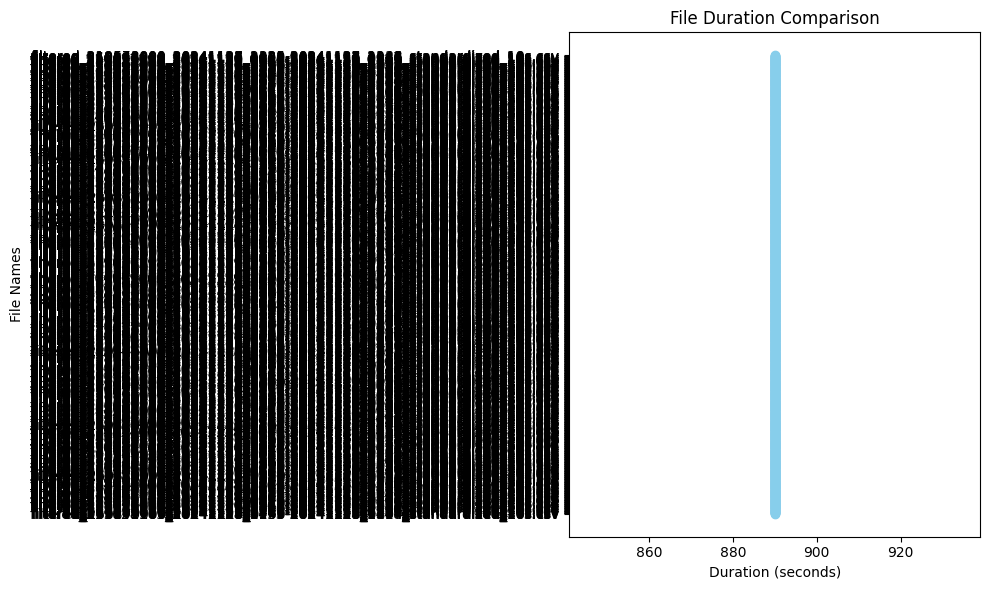

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Specify the folder path where your CSV files are located
folder_path = './time_sets_standardized'

# Lists to store file names and their durations
file_names = []
durations = []

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert 'Timestamp' to datetime format
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Calculate the duration (time between first and last timestamp)
        time_diff = df['Timestamp'].max() - df['Timestamp'].min()

        # Append the file name and duration
        file_names.append(filename)
        durations.append(time_diff.total_seconds())  # Convert to seconds for easy comparison

# Scatter plot with durations on the x-axis
plt.figure(figsize=(10, 6))
plt.scatter(durations, file_names, color='skyblue')
plt.xlabel('Duration (seconds)')
plt.ylabel('File Names')
plt.title('File Duration Comparison')

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
import os
import pandas as pd

def check_underway_sog(folder, sog_threshold):
    # Step 1: Get all CSV files in the specified folder
    csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]

    for csv_file in csv_files:
        file_path = os.path.join(folder, csv_file)
        try:
            # Step 2: Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Step 3: Check if the navigational status is "Underway using engine" and SOG is above threshold
            if 'Navigational status' in df.columns and 'SOG' in df.columns:
                # Assuming there is only one row (vessel) per file, we directly check the condition
                navigational_status = df['Navigational status'].iloc[0]  # First row, first column value
                sog = df['SOG'].iloc[0]  # First row, first column value

                if navigational_status == 'Underway using engine' and sog > sog_threshold:
                    print(f"File {csv_file}: Vessel is 'Underway using engine' with SOG above {sog_threshold}")
            else:
                print(f"File {csv_file}: Missing required columns ('Navigational status' or 'SOG').")

        except Exception as e:
            print(f"Failed to process {csv_file}: {e}")

# Example usage:
folder = 'time_sets_st_shortened'  # Replace with your folder path
sog_threshold = 5.0  # Example threshold for SOG (e.g., 5 knots)

check_underway_sog(folder, sog_threshold)
